# Gameplan:

1. Set up data
2. Create subset for Excel
3. Make a prediction w Dot Product
4. Analyze results
5. Try a neural net.

In [1]:
from theano.sandbox import cuda

Using cuDNN version 5103 on context None
Preallocating 10867/11439 Mb (0.950000) on cuda
Mapped name None to device cuda: Tesla K40c (0000:81:00.0)


SkipTest: You are importing theano.sandbox.cuda. This is the old GPU back-end and is removed from Theano. Use Theano 0.9 to use it. Even better, transition to the new GPU back-end! See https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

In [2]:
%matplotlib inline
import utils; reload(utils)
from utils import *
from __future__ import division, print_function

Using Theano backend.


In [6]:
path = "data/ml-small/ml-latest-small/"
model_path = path + 'models/'
if not os.path.exists(model_path): os.mkdir(model_path)
batch_size = 64

# Setup

We'll read in the ratings using read_csv function from Pandas, which reads a csv file into a pandas dataframe--a 2D size-mutable tabular data structure w/ labeled rows and columns. It's a dict-like container fro series objects.
We'll return the head of the dataframe, which by default is set to n=5 rows.

In [7]:
ratings = pd.read_csv(path+'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [8]:
len(ratings) #how many?

100004

We'll read in movie names for display purposes
We'll use set_index, a dataframe functiuon that will give us info from the column label. to_dict will just convert this to a dictionary

In [12]:
movie_names_prelim = pd.read_csv(path+'ratings.csv').set_index('movieId').to_dict()
print(movie_names_prelim["title"])

KeyError: 'title'

In [66]:
movie_names = pd.read_csv(path+'movies.csv').set_index('movieId')['title'].to_dict()

We'll grab users/movies as the unique values from ratings.

In [13]:
users = ratings.userId.unique()
movies = ratings.movieId.unique()

In [15]:
print(users[:5])
print(movies[:10])

[1 2 3 4 5]
[  31 1029 1061 1129 1172 1263 1287 1293 1339 1343]


We'll reverse order of users,movies by flipping things. we use enumerate() which adds a counter to an iterable--it starts from 0 and will count from there.
It will update movie and user ids so that they are contiguous integers--this helps us use embeddings.

In [16]:
userid2idx = {o:i for i,o in enumerate(users)}
movieid2idx = {o:i for i,o in enumerate(movies)}

We'll reorder the ratings/users in our ratings DataFrame by using apply, which applies a function along the input axis of a DataFrame. This'll make sure things in our frame our ordered when we use them.

In [18]:
ratings.movieId = ratings.movieId.apply(lambda(x): movieid2idx[x])
ratings.userId = ratings.userId.apply(lambda(x): userid2idx[x])

In [19]:
user_min, user_max, movie_min, movie_max = (ratings.userId.min(),
    ratings.userId.max(), ratings.movieId.min(), ratings.movieId.max())
user_min, user_max, movie_min, movie_max

(0, 670, 0, 9065)

In [21]:
# now to get the number of users and movies using nunique(), not unique()
n_users = ratings.userId.nunique()
n_movies = ratings.movieId.nunique()
n_users,n_movies

(671, 9066)

671,9066 are the number of latent factors in each embedding.

In [22]:
n_factors = 50

In [23]:
np.random.seed = 42 #seeds a generator--for when we want repeatable results.

Now split into training and validation
random.rand creates an array of the given shape and will populate it with values from a uniform distribution over [0,1)--since we say to be less than 0.8, the values in the array that are less than 0.8 will show up as true, and thsoe that are not will be replaced with a value of false.

In [27]:
things = [1,2,3,4,5]
rand_toy = np.random.rand(len(things)) < 0.7
print(rand_toy)
print(rand_toy[~things])

[False False  True  True  True]


TypeError: bad operand type for unary ~: 'list'

We use the tilde operator for validation--it's the invert/complement operation. So bascially trn should be all ratings less than 0.8 and val should be those more than 0.8 (?)

In [28]:
msk = np.random.rand(len(ratings)) < 0.8
trn = ratings[msk]
val = ratings[~msk]

# Subset for Excel

We now get the most popular movies and most addicted users to copy into excel.
We'll use pandas groupby to group series of things by key or a series of columns

In [30]:
g=ratings.groupby('userId')['rating'].count() #count returns a series w/ number of non-null observations over the requested axis
topUsers=g.sort_values(ascending=False)[:15] #top 15 users

In [33]:
g=ratings.groupby('movieId')['rating'].count()
topMovies=g.sort_values(ascending=False)[:15]

In [32]:
top_r = ratings.join(topUsers, rsuffix='_r', how='inner', on='userId') #rsuffix is used from right frame's overlapping columns
#inner will form an intersection of calling frame's index with the other frame's index preserving the order othe calling one
#on is the column in the caller (ratings) to join the index in other

In [34]:
top_r = top_r.join(topMovies, rsuffix='_r', how='inner', on='movieId')

In [35]:
pd.crosstab(top_r.userId, top_r.movieId, top_r.rating, aggfunc=np.sum) #creates a crosstab of 2+ factors

movieId,27,49,57,72,79,89,92,99,143,179,180,197,402,417,505
userId,,,,,,,,,,,,,,,
14,3.0,5.0,1.0,3.0,4.0,4.0,5.0,2.0,5.0,5.0,4.0,5.0,5.0,2.0,5.0
29,5.0,5.0,5.0,4.0,5.0,4.0,4.0,5.0,4.0,4.0,5.0,5.0,3.0,4.0,5.0
72,4.0,5.0,5.0,4.0,5.0,3.0,4.5,5.0,4.5,5.0,5.0,5.0,4.5,5.0,4.0
211,5.0,4.0,4.0,3.0,5.0,3.0,4.0,4.5,4.0,NaN,3.0,3.0,5.0,3.0,NaN
212,2.5,NaN,2.0,5.0,NaN,4.0,2.5,NaN,5.0,5.0,3.0,3.0,4.0,3.0,2.0
293,3.0,NaN,4.0,4.0,4.0,3.0,NaN,3.0,4.0,4.0,4.5,4.0,4.5,4.0,NaN
310,3.0,3.0,5.0,4.5,5.0,4.5,2.0,4.5,4.0,3.0,4.5,4.5,4.0,3.0,4.0
379,5.0,5.0,5.0,4.0,NaN,4.0,5.0,4.0,4.0,4.0,NaN,3.0,5.0,4.0,4.0
451,4.0,5.0,4.0,5.0,4.0,4.0,5.0,5.0,4.0,4.0,4.0,4.0,2.0,3.5,5.0


# Dot Product

In [36]:
user_in = Input(shape=(1,),dtype='int64',name='user_in')
u = Embedding(n_users,n_factors,input_length=1,W_regularizer=l2(1e-4))(user_in)
# turns positive integers (indexes) into dense vectors of a fixed size. input_dim is n_users, output is n_factors. 
movie_in = Input(shape=(1,),dtype='int64',name='movie_in')
m = Embedding(n_movies,n_factors,input_length=1,W_regularizer=l2(1e-4))(movie_in)

In [37]:
x = merge([u,m], mode='dot')
x = Flatten()(x)
model = Model([user_in,movie_in],x) #we're using functional api and giving multiple inputs to the model
model.compile(Adam(0.001),loss='mse')

In [40]:
model.fit([trn.userId,trn.movieId],trn.rating,batch_size=64,nb_epoch=1,
         validation_data=([val.userId,val.movieId],val.rating))

Train on 79983 samples, validate on 20021 samples
Epoch 1/1
79983/79983 [==============================] - 2s - loss: 9.9152 - val_loss: 4.3311


In [41]:
model.optimizer.lr=0.01

In [42]:
model.fit([trn.userId,trn.movieId],trn.rating,batch_size=64,nb_epoch=1,
         validation_data=([val.userId,val.movieId],val.rating))

Train on 79983 samples, validate on 20021 samples
Epoch 1/1
79983/79983 [==============================] - 3s - loss: 3.1290 - val_loss: 2.8549


In [43]:
model.optimizer.lr=0.001

In [44]:
model.fit([trn.userId,trn.movieId],trn.rating,batch_size=64,nb_epoch=6,
         validation_data=([val.userId,val.movieId],val.rating))

Train on 79983 samples, validate on 20021 samples
Epoch 1/6
79983/79983 [==============================] - 2s - loss: 2.3947 - val_loss: 2.6446
Epoch 2/6
79983/79983 [==============================] - 2s - loss: 2.2220 - val_loss: 2.5943
Epoch 3/6
79983/79983 [==============================] - 2s - loss: 2.1538 - val_loss: 2.5857
Epoch 4/6
79983/79983 [==============================] - 2s - loss: 2.1194 - val_loss: 2.5840
Epoch 5/6
79983/79983 [==============================] - 2s - loss: 2.0936 - val_loss: 2.5918
Epoch 6/6
79983/79983 [==============================] - 2s - loss: 2.0742 - val_loss: 2.5981


# Bias

We need a single bias for each user / each movie representing how positive/negative each user is, and how good each movie is.
To get this, we'll create an embedding w one output for each movie and each user, and add it to our output.

In [45]:
def embedding_input(name, n_in, n_out, reg):
    inp = Input(shape=(1,),dtype='int64',name=name)
    return inp, Embedding(n_in,n_out,input_length=1, W_regularizer=l2(reg))(inp)

In [46]:
user_in, u = embedding_input('user_in', n_users, n_factors, 1e-4)
movie_in, m = embedding_input('movie_in', n_movies, n_factors, 1e-4)

In [47]:
def create_bias(inp, n_in):
    x = Embedding(n_in, 1, input_length=1)(inp) #n_in is the input to embedding layer, output is 1 number
    return Flatten()(x)

In [48]:
ub = create_bias(user_in,n_users)
mb = create_bias(movie_in,n_movies)

In [50]:
x = merge([u,m],mode='dot')
x = Flatten()(x)
x = merge([x,ub],mode='sum') #add user bias to our dot product
x = merge([x,mb],mode='sum') #add movie bias to dot product
model = Model([user_in,movie_in],x)
model.compile(Adam(0.001),loss='mse')

In [51]:
model.fit([trn.userId,trn.movieId],trn.rating, batch_size=64, nb_epoch=1,
          validation_data=([val.userId,val.movieId],val.rating))

Train on 79983 samples, validate on 20021 samples
Epoch 1/1
79983/79983 [==============================] - 3s - loss: 8.7959 - val_loss: 3.5443


In [52]:
model.optimizer.lr=0.01

In [53]:
model.fit([trn.userId,trn.movieId],trn.rating,batch_size=64,nb_epoch=6,
         validation_data=([val.userId,val.movieId],val.rating))

Train on 79983 samples, validate on 20021 samples
Epoch 1/6
79983/79983 [==============================] - 3s - loss: 2.5850 - val_loss: 2.3491
Epoch 2/6
79983/79983 [==============================] - 3s - loss: 2.0054 - val_loss: 2.1441
Epoch 3/6
79983/79983 [==============================] - 3s - loss: 1.8466 - val_loss: 2.0458
Epoch 4/6
79983/79983 [==============================] - 3s - loss: 1.7494 - val_loss: 1.9684
Epoch 5/6
79983/79983 [==============================] - 3s - loss: 1.6680 - val_loss: 1.9001
Epoch 6/6
79983/79983 [==============================] - 3s - loss: 1.5922 - val_loss: 1.8331


In [54]:
model.optimizer.lr=0.001

In [56]:
model.fit([trn.userId,trn.movieId],trn.rating,batch_size=64,nb_epoch=10,
         validation_data=([val.userId,val.movieId],val.rating))

Train on 79983 samples, validate on 20021 samples
Epoch 1/10
79983/79983 [==============================] - 3s - loss: 1.4489 - val_loss: 1.6987
Epoch 2/10
79983/79983 [==============================] - 3s - loss: 1.3800 - val_loss: 1.6432
Epoch 3/10
79983/79983 [==============================] - 3s - loss: 1.3125 - val_loss: 1.5846
Epoch 4/10
79983/79983 [==============================] - 3s - loss: 1.2480 - val_loss: 1.5366
Epoch 5/10
79983/79983 [==============================] - 3s - loss: 1.1877 - val_loss: 1.4838
Epoch 6/10
79983/79983 [==============================] - 3s - loss: 1.1289 - val_loss: 1.4371
Epoch 7/10
79983/79983 [==============================] - 3s - loss: 1.0739 - val_loss: 1.3922
Epoch 8/10
79983/79983 [==============================] - 3s - loss: 1.0210 - val_loss: 1.3485
Epoch 9/10
79983/79983 [==============================] - 3s - loss: 0.9713 - val_loss: 1.3127
Epoch 10/10
79983/79983 [==============================] - 3s - loss: 0.9246 - val_loss: 1.2769

In [57]:
model.fit([trn.userId,trn.movieId],trn.rating,batch_size=64,nb_epoch=5,
         validation_data=([val.userId,val.movieId],val.rating))

Train on 79983 samples, validate on 20021 samples
Epoch 1/5
79983/79983 [==============================] - 3s - loss: 0.8814 - val_loss: 1.2434
Epoch 2/5
79983/79983 [==============================] - 3s - loss: 0.8409 - val_loss: 1.2137
Epoch 3/5
79983/79983 [==============================] - 3s - loss: 0.8031 - val_loss: 1.1846
Epoch 4/5
79983/79983 [==============================] - 3s - loss: 0.7694 - val_loss: 1.1618
Epoch 5/5
79983/79983 [==============================] - 3s - loss: 0.7378 - val_loss: 1.1381


In [58]:
model.save_weights(model_path+'bias.h5')
model.load_weights(model_path+'bias.h5')

In [61]:
model.predict([np.array([3]), np.array([6])])

array([[ 4.7984]], dtype=float32)

# Results

In [80]:
g=ratings.groupby('movieId')['rating'].count()
topMovies=g.sort_values(ascending=False)[:2000]
topMovies=np.array(topMovies.index)

We'll look at the movie bias term--create a model (inputs associated w outputs) using fxnl api. Input is movie id and output is bias

In [81]:
get_movie_bias = Model(movie_in,mb)
movie_bias = get_movie_bias.predict(topMovies)
movie_ratings = [(b[0], movie_names[movies[i]]) for i,b in zip(topMovies,movie_bias)]

sorted(movie_ratings,key=itemgetter(0))[:15]

[(-0.31427297, 'Battlefield Earth (2000)'),
 (-0.17773028, 'Police Academy 5: Assignment: Miami Beach (1988)'),
 (-0.14297776, 'Speed 2: Cruise Control (1997)'),
 (-0.089551203, 'Jaws 3-D (1983)'),
 (-0.048208863, 'Super Mario Bros. (1993)'),
 (-0.041385461, 'Little Nicky (2000)'),
 (-0.026831176, 'Wild Wild West (1999)'),
 (-0.02015092, 'Bio-Dome (1996)'),
 (-0.0020950385, 'Spice World (1997)'),
 (0.017065659, 'Blade: Trinity (2004)'),
 (0.022020709, '2 Fast 2 Furious (Fast and the Furious 2, The) (2003)'),
 (0.027149543, 'Twilight (2008)'),
 (0.032843266, 'Batman & Robin (1997)'),
 (0.042215884, 'Haunting, The (1999)'),
 (0.042389758, 'Blair Witch Project, The (1999)')]

In [82]:
sorted(movie_ratings,key=itemgetter(0),reverse=True)[:15] #bottom rated movies

[(1.5026755, 'Tom Jones (1963)'),
 (1.4728292, 'Rush (2013)'),
 (1.4628012, 'Porco Rosso (Crimson Pig) (Kurenai no buta) (1992)'),
 (1.4090048, "Howl's Moving Castle (Hauru no ugoku shiro) (2004)"),
 (1.4002928, 'Sandlot, The (1993)'),
 (1.3829172, 'Harry Potter and the Deathly Hallows: Part 2 (2011)'),
 (1.3733261, 'My Neighbor Totoro (Tonari no Totoro) (1988)'),
 (1.3586637, 'Shawshank Redemption, The (1994)'),
 (1.3326802, 'Lifeboat (1944)'),
 (1.3316891, 'Cyrano de Bergerac (1990)'),
 (1.3285786, "Once Upon a Time in the West (C'era una volta il West) (1968)"),
 (1.3244253, 'The Theory of Everything (2014)'),
 (1.3231812, 'On the Waterfront (1954)'),
 (1.3205156, 'Argo (2012)'),
 (1.313627, 'Grave of the Fireflies (Hotaru no haka) (1988)')]

In [83]:
get_movie_emb = Model(movie_in,m)
movie_emb = np.squeeze(get_movie_emb.predict([topMovies]))
movie_emb.shape

(2000, 50)

In [84]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3) #reduce to 3 vectors/embeddings
movie_pca = pca.fit(movie_emb.T).components_

In [85]:
fac0 = movie_pca[0]

In [86]:
movie_comp = [(f,movie_names[movies[i]]) for f,i in zip(fac0,topMovies)]

First comopnent of the 3 vectors:

In [87]:
sorted(movie_comp,key=itemgetter(0),reverse=True)[:10]

[(0.012611528, 'Battlefield Earth (2000)'),
 (0.011758162, 'Anaconda (1997)'),
 (0.011143663, 'Police Academy 6: City Under Siege (1989)'),
 (0.010436111, 'Grease 2 (1982)'),
 (0.010191719, 'Super Mario Bros. (1993)'),
 (0.010049743, 'Police Academy 3: Back in Training (1986)'),
 (0.0092158532,
  'Highlander III: The Sorcerer (a.k.a. Highlander: The Final Dimension) (1994)'),
 (0.0090234401, 'Island of Dr. Moreau, The (1996)'),
 (0.0084614167, 'Mighty Morphin Power Rangers: The Movie (1995)'),
 (0.0082162162, 'RoboCop 3 (1993)')]

In [88]:
sorted(movie_comp,key=itemgetter(0))[:10]

[(-0.0527055, 'Usual Suspects, The (1995)'),
 (-0.052363563, "Amelie (Fabuleux destin d'Am\xc3\xa9lie Poulain, Le) (2001)"),
 (-0.05229979, 'Wallace & Gromit: The Wrong Trousers (1993)'),
 (-0.051068608, 'Wallace & Gromit: A Close Shave (1995)'),
 (-0.050899711, 'Star Wars: Episode VI - Return of the Jedi (1983)'),
 (-0.050616972, 'Monty Python and the Holy Grail (1975)'),
 (-0.050495889, 'Star Wars: Episode V - The Empire Strikes Back (1980)'),
 (-0.049928404, 'Star Wars: Episode IV - A New Hope (1977)'),
 (-0.049442172, 'American Beauty (1999)'),
 (-0.049060397, "Ferris Bueller's Day Off (1986)")]

In [89]:
fac1= movie_pca[1]

In [90]:
movie_comp = [(f,movie_names[movies[i]]) for f,i in zip(fac1,topMovies)]

Second reduced component

In [92]:
sorted(movie_comp,key=itemgetter(0),reverse=True)[:10]

[(0.10118026, 'Independence Day (a.k.a. ID4) (1996)'),
 (0.090775184, 'Armageddon (1998)'),
 (0.074230298, 'Stargate (1994)'),
 (0.072134405, 'Star Trek: First Contact (1996)'),
 (0.071724825, 'Speed (1994)'),
 (0.071177177, 'Star Wars: Episode I - The Phantom Menace (1999)'),
 (0.07093171, 'True Lies (1994)'),
 (0.069787718, 'Titanic (1997)'),
 (0.069080755, 'X-Men (2000)'),
 (0.068311185, 'Rock, The (1996)')]

In [93]:
sorted(movie_comp,key=itemgetter(0))[:10]

[(-0.063370824, '2001: A Space Odyssey (1968)'),
 (-0.060410995, 'Annie Hall (1977)'),
 (-0.056936454, 'Clockwork Orange, A (1971)'),
 (-0.055596121, 'Bringing Up Baby (1938)'),
 (-0.054436982, 'Harold and Maude (1971)'),
 (-0.054149397, 'City Lights (1931)'),
 (-0.053914025, 'Manhattan (1979)'),
 (-0.052987523, 'Blue Velvet (1986)'),
 (-0.051917091, 'Taxi Driver (1976)'),
 (-0.051823687, 'Big Lebowski, The (1998)')]

In [94]:
fac2 = movie_pca[2]

In [95]:
movie_comp = [(f,movie_names[movies[i]]) for f,i in zip(fac2,topMovies)]

In [97]:
sorted(movie_comp,key=itemgetter(0),reverse=True)[:10]

[(0.1110149, 'Seven (a.k.a. Se7en) (1995)'),
 (0.099627174, 'Star Wars: Episode V - The Empire Strikes Back (1980)'),
 (0.09665481, 'Lord of the Rings: The Two Towers, The (2002)'),
 (0.09177684, 'Matrix, The (1999)'),
 (0.091222547, 'Fight Club (1999)'),
 (0.084761992, 'Star Wars: Episode VI - Return of the Jedi (1983)'),
 (0.081920668, 'Silence of the Lambs, The (1991)'),
 (0.080623575, 'Dumb & Dumber (Dumb and Dumber) (1994)'),
 (0.078710385, 'Lord of the Rings: The Fellowship of the Ring, The (2001)'),
 (0.071084477, 'Dark Knight, The (2008)')]

In [98]:
sorted(movie_comp,key=itemgetter(0))[:10]

[(-0.078399226, 'Sabrina (1995)'),
 (-0.077993959, "You've Got Mail (1998)"),
 (-0.068608589, 'Sleepless in Seattle (1993)'),
 (-0.066780455, 'Chicago (2002)'),
 (-0.061384264, '13 Going on 30 (2004)'),
 (-0.060411051, 'Shakespeare in Love (1998)'),
 (-0.060391914, 'Pay It Forward (2000)'),
 (-0.06007871, 'Bend It Like Beckham (2002)'),
 (-0.059999581, 'Double Jeopardy (1999)'),
 (-0.055835746, 'Nell (1994)')]

In [100]:
import sys
stdout, stderror = sys.stdout, sys.stderr #svae stdout, stderr
reload(sys)
sys.setdefaultencoding('utf-8')
sys.stdout,sys.stderr = stdout,stderror

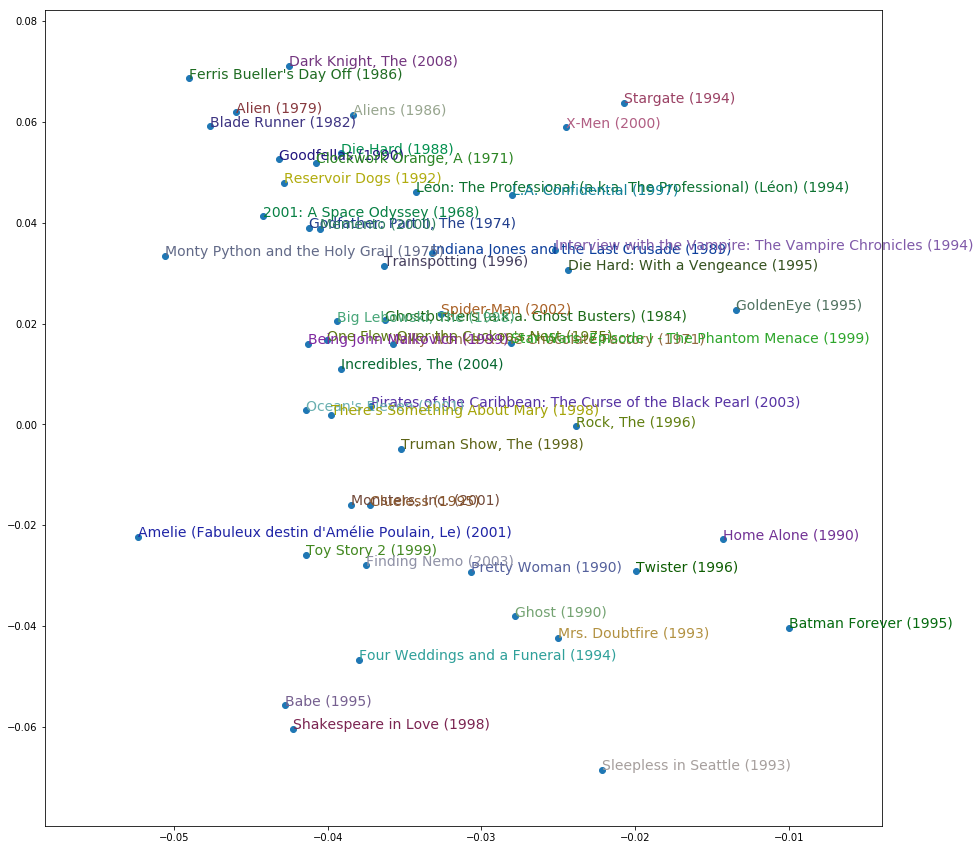

In [102]:
start=50;end=100
X = fac0[start:end]
Y = fac2[start:end]
plt.figure(figsize=(15,15))
plt.scatter(X,Y)
for i,x,y in zip(topMovies[start:end],X,Y):
    plt.text(x,y,movie_names[movies[i]],color=np.random.rand(3)*0.7, fontsize=14)
plt.show()

# Neural Net

In [103]:
user_in, u = embedding_input('user_in', n_users, n_factors, 1e-4)
movie_in, m = embedding_input('movie_in', n_movies, n_factors, 1e-4)

In [104]:
x = merge([u,m], mode='concat') #we concatenate user/movie embeddings into a vector to feed into the NN
x = Flatten()(x)
x = Dropout(0.3)(x)
x = Dense(70,activation='relu')(x)
x = Dropout(0.75)(x)
x = Dense(1)(x)
nn = Model([user_in,movie_in],x)
nn.compile(Adam(0.001),loss='mse')

In [106]:
nn.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=8, 
          validation_data=([val.userId, val.movieId], val.rating))

Looks like the neural net is a good way to go!